In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from astropy import units as u
import astropy.coordinates as coord
from mpl_toolkits import mplot3d
from sklearn.datasets import make_blobs
import seaborn as sns
import hdbscan
import math
import itertools
import pickle
from sklearn.preprocessing import StandardScaler

import time

In [91]:
#we make a function from all the other data
def ClusterAndCrossmatch(field, clust_mean, clust, clustername, doclust):
    clust_mean = clust_mean.query(f'oc == "{clustername}"')
    clust = clust.query(f'cluster == "{clustername}"')
    magnitudecut = np.arange(12, np.max(clust['phot_g_mean_mag']) +1)
    field = field.query(f'phot_g_mean_mag < {np.max(magnitudecut)}')

    #make the 4 plots

    plt.figure(figsize=(12,12))
    #plot 1, ra and dec
    plt.subplot(2,2,1)
    plt.scatter(field['ra'], field['dec'], c='grey', s = 0.1 , alpha=0.1)
    plt.scatter(clust['ra'], clust['dec'], c = 'blue')
    plt.xlabel('RA')
    plt.ylabel('Dec')

    #plot 2, pmra and pmdec
    plt.subplot(2,2,2)
    plt.scatter(field['pmra'], field['pmdec'], c='grey', s = 1 , alpha=0.5)
    plt.scatter(clust['pmra'], clust['pmdec'], c = 'blue')
    plt.xlim((clust_mean['medPmra'] - 10*clust_mean['sigPmra']).min(), (clust_mean['medPmra'] + 10*clust_mean['sigPmra']).max())
    plt.ylim((clust_mean['medPmdec'] - 10*clust_mean['sigPmdec']).min(), (clust_mean['medPmdec'] + 10*clust_mean['sigPmdec']).max())
    plt.xlabel('pmra')
    plt.ylabel('pmdec')

    #plot 3, parallax and G
    plt.subplot(2,2,3)
    plt.scatter(field['phot_g_mean_mag'], field['parallax'], c='grey', s = 1 , alpha=0.5)
    plt.scatter(clust['phot_g_mean_mag'], clust['parallax'], c = 'blue')
    plt.ylim(0, np.max(clust['parallax']) + 1)
    plt.xlabel('G')
    plt.ylabel('Parallax')

    #plot 4, bp_rp and G
    plt.subplot(2,2,4)
    plt.scatter(field['bp_rp'], field['phot_g_mean_mag'], c='grey', s = 1 , alpha=0.5)
    plt.scatter(clust['bp_rp'], clust['phot_g_mean_mag'], c = 'blue')
    plt.ylim(10,np.ceil(np.max(magnitudecut)))
    plt.xlim(-0.5,3)
    plt.xlabel('BP-RP')
    plt.ylabel('G')
    plt.gca().invert_yaxis()
    plt.show()

    #now cluster and crossmatch

    purityarray = np.array([])
    completenessarray = np.array([])
    


    for i in magnitudecut:
        print(f'G <= {i}')
        cutfield = field.query(f'phot_g_mean_mag < {i}')
        clust_ID = np.array(clust.query(f'phot_g_mean_mag <={i}')['source_id'])
        field_ID = np.array(cutfield['source_id'])
        print(f'\tOC members: {len(clust_ID)}')
        cutfield = cutfield.dropna().query('phot_g_mean_mag <= @i ').query('0 < parallax < 7').query('-30 < pmra < 30').query('-30 < pmdec < 30')
        print(f'\tField stars: {len(cutfield)}')
        
        #scale the data
        data_scaled = StandardScaler().fit_transform(np.array(cutfield[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]))
        scaled_frame = pd.DataFrame(data_scaled, columns = ['ra', 'dec', 'parallax', 'pmra', 'pmdec'], dtype=float)
        
        #determine a minimum cluster size and cluster the data, or load the data
        if doclust == True:
            clustersize = min(10, len(clust.query(f'phot_g_mean_mag<= {i}')))
            clusterer = hdbscan.HDBSCAN(min_cluster_size=clustersize, min_samples=10, cluster_selection_method = 'leaf')
            clusterer.fit(scaled_frame)

            #save the clusterer
            with open(f'Data\\{clustername}\\clusterer\\clusterer_{clustername}_mag{i}.pkl', 'wb') as f:
                pickle.dump(clusterer, f)
       
        elif doclust == False:
            with open(f'Data\\{clustername}\\clusterer\\clusterer_{clustername}_mag{i}.pkl', 'rb') as f:
                clusterer = pickle.load(f)
        print(f'\t# HDBscan Groups: {len(np.unique(clusterer.labels_))-1}')

        #crossmatch the data and calculate purity and completeness
        

        complete_crossmatch = np.array([])
        group_members = np.array([])
        for j in np.unique(clusterer.labels_):
            if j == -1: continue
            group_idex = clusterer.labels_ == j
            group_ID = np.array(cutfield['source_id'][group_idex])
            crossmatch = np.array([True if x in clust_ID else False for x in group_ID])

            if np.sum(crossmatch) > 0:
                members = len(group_ID)
                crossmatch_amount = np.sum(crossmatch)
                print(f'\t\tGroup {j}:')
                print(f'\t\t\t # members: {members}')
                print(f'\t\t\t # crossmatched stars: {crossmatch_amount}')
                complete_crossmatch = np.append(complete_crossmatch, crossmatch_amount)
                group_members = np.append(group_members, members)
            elif np.sum(crossmatch) == 0:
                complete_crossmatch = np.append(complete_crossmatch, 0)

        crossmatched_total = np.sum(complete_crossmatch)
        total_members = np.sum(group_members)
        
        if total_members == 0:
            purity = 0
        else:
            purity = crossmatched_total/total_members
        completeness = crossmatched_total/len(clust_ID)
        print(total_members)

        purityarray = np.append(purityarray, purity)
        completenessarray = np.append(completenessarray, completeness)
        print(f'\tPurity: {purity}')
        print(f'\tCompleteness: {completeness}')

    return purityarray, completenessarray

    

In [96]:
field_UBC21 = pd.read_csv('Data\\UBC21-result.csv')
field_COIN = pd.read_csv('Data\\COIN-result.csv')
field_Platais10 = pd.read_csv('Data\\Platais-result.csv')
field_UBC14 = pd.read_csv('Data\\UBC14-result.csv')
field_UBC13 = pd.read_csv('Data\\UBC13-result.csv')

field_UPK495 = pd.read_csv('Data\\UPK_495-result.csv')
field_UPK533 = pd.read_csv('Data\\UPK533-result.csv')

#Special Case for UPK654, I will explain in the report
UPK654second = pd.read_csv('Data\\SecondUPK654-result.csv')
UPK654first = pd.read_csv('Data\\FirstUPK654-result.csv')

field_UPK654 = pd.concat([UPK654first, UPK654second])


mean_dr3 = pd.read_csv('Data\\oc_means_dr3.csv')
memb_dr3 = pd.read_csv('Data\\members_kept_2681_OCs.csv')

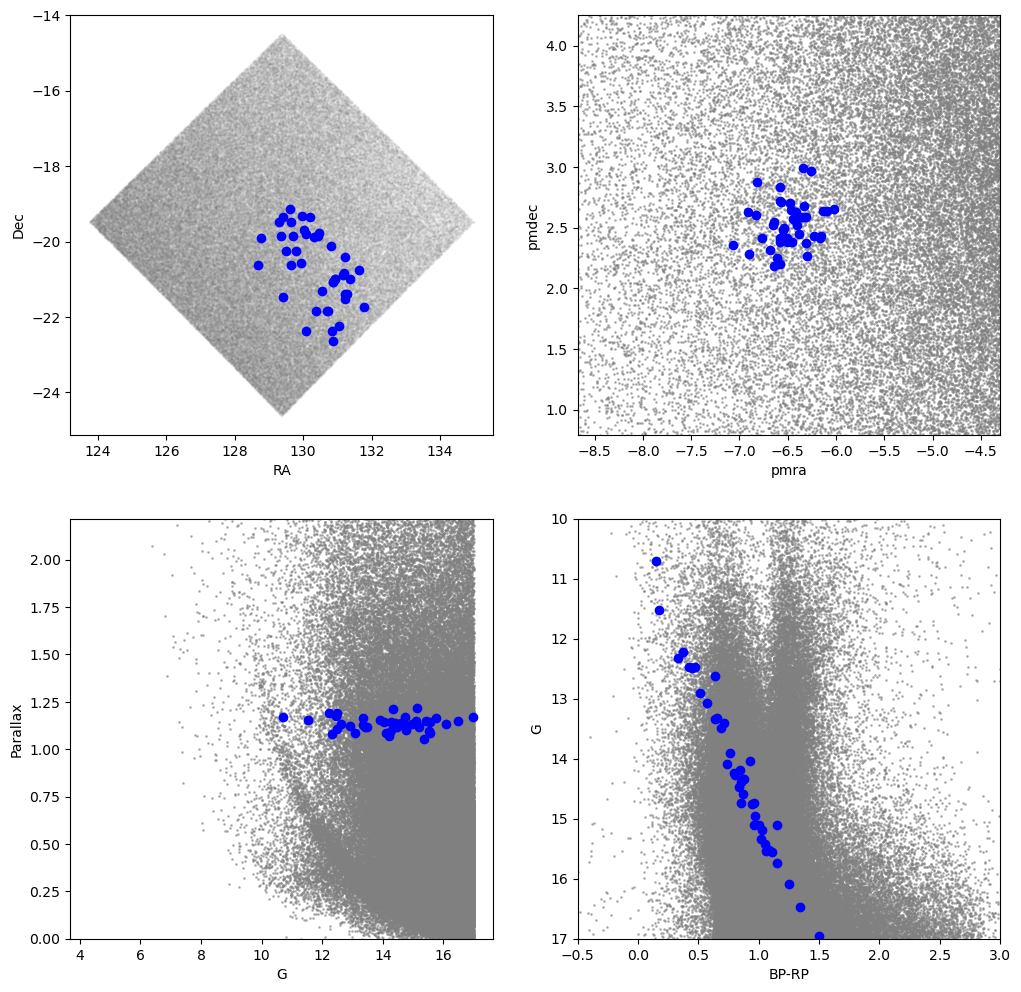

G <= 12.0
	OC members: 2
	Field stars: 5328
	# HDBscan Groups: 46
0.0
	Purity: 0
	Completeness: 0.0
G <= 13.0
	OC members: 9
	Field stars: 12771
	# HDBscan Groups: 21
		Group 0:
			 # members: 9
			 # crossmatched stars: 2
9.0
	Purity: 0.2222222222222222
	Completeness: 0.2222222222222222
G <= 14.0
	OC members: 15
	Field stars: 28609
	# HDBscan Groups: 15
0.0
	Purity: 0
	Completeness: 0.0
G <= 15.0
	OC members: 29
	Field stars: 61386
	# HDBscan Groups: 51
		Group 0:
			 # members: 18
			 # crossmatched stars: 9
		Group 1:
			 # members: 31
			 # crossmatched stars: 10
49.0
	Purity: 0.3877551020408163
	Completeness: 0.6551724137931034
G <= 16.0
	OC members: 39
	Field stars: 126855
	# HDBscan Groups: 73
		Group 1:
			 # members: 48
			 # crossmatched stars: 16
		Group 3:
			 # members: 12
			 # crossmatched stars: 7
60.0
	Purity: 0.38333333333333336
	Completeness: 0.5897435897435898
G <= 17.0
	OC members: 42
	Field stars: 237951
	# HDBscan Groups: 139
		Group 5:
			 # members: 46
			 # cr

In [92]:
purity21, completeness21 = ClusterAndCrossmatch(field_UBC21, mean_dr3, memb_dr3, 'UBC_21', doclust=False)


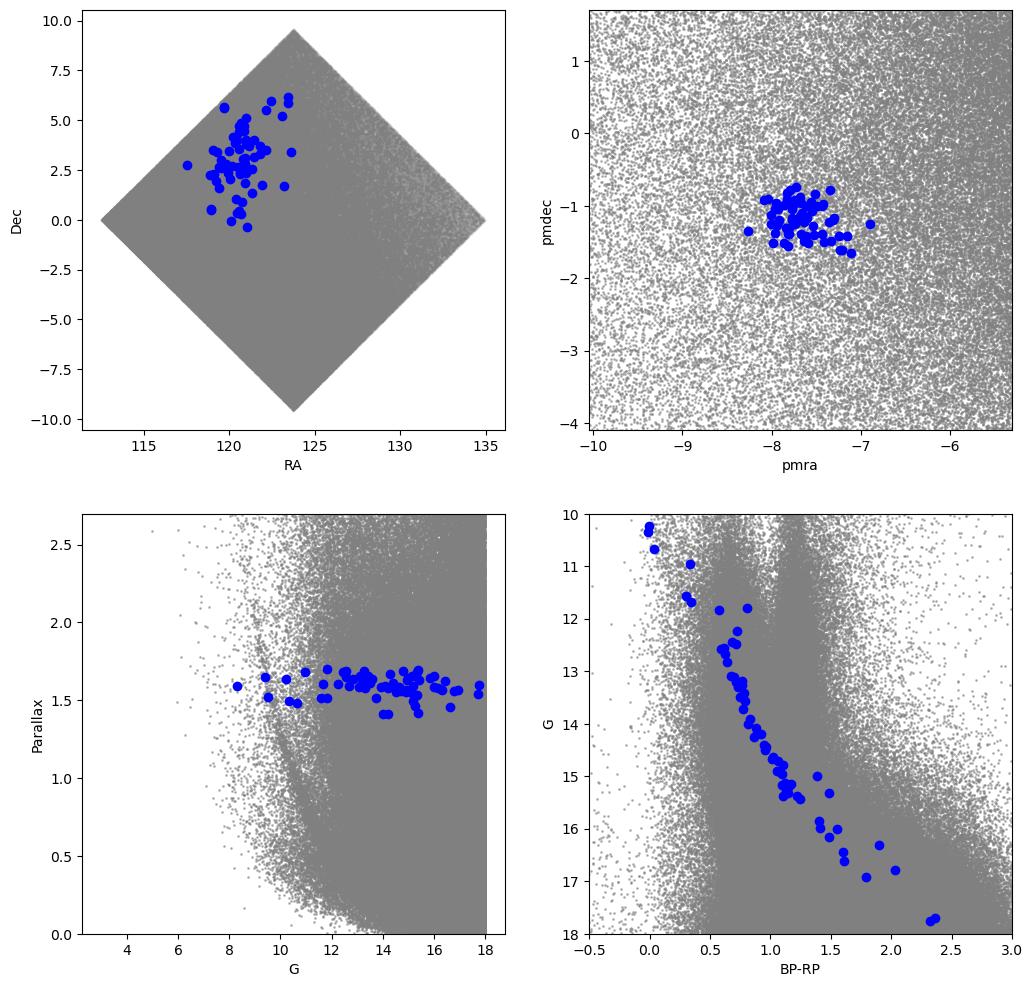

G <= 12.0
	OC members: 11
	Field stars: 16640
	# HDBscan Groups: 19
		Group 1:
			 # members: 14
			 # crossmatched stars: 4
14.0
	Purity: 0.2857142857142857
	Completeness: 0.36363636363636365
G <= 13.0
	OC members: 18
	Field stars: 38123
	# HDBscan Groups: 28
		Group 2:
			 # members: 16
			 # crossmatched stars: 2
		Group 6:
			 # members: 10
			 # crossmatched stars: 3
		Group 7:
			 # members: 16
			 # crossmatched stars: 6
42.0
	Purity: 0.2619047619047619
	Completeness: 0.6111111111111112
G <= 14.0
	OC members: 30
	Field stars: 81724
	# HDBscan Groups: 43
		Group 2:
			 # members: 23
			 # crossmatched stars: 1
		Group 5:
			 # members: 16
			 # crossmatched stars: 4
		Group 6:
			 # members: 39
			 # crossmatched stars: 17
78.0
	Purity: 0.28205128205128205
	Completeness: 0.7333333333333333
G <= 15.0
	OC members: 45
	Field stars: 170750
	# HDBscan Groups: 84
		Group 5:
			 # members: 22
			 # crossmatched stars: 2
		Group 10:
			 # members: 12
			 # crossmatched stars: 4
		Group 1

In [93]:
purity13, completeness13 = ClusterAndCrossmatch(field_UBC13, mean_dr3, memb_dr3, 'UBC_13', doclust=False)


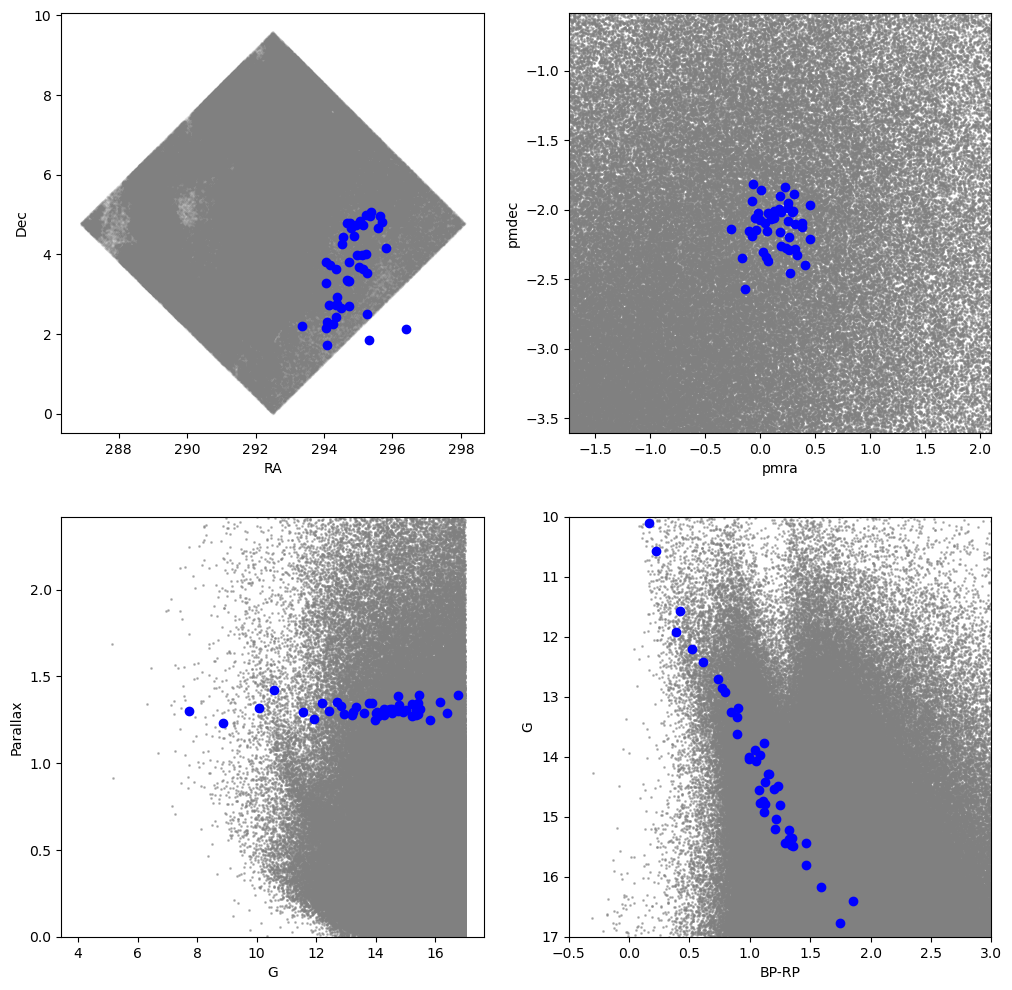

G <= 12.0
	OC members: 6
	Field stars: 8827
	# HDBscan Groups: 18
0.0
	Purity: 0
	Completeness: 0.0
G <= 13.0
	OC members: 11
	Field stars: 25800
	# HDBscan Groups: 22
		Group 0:
			 # members: 20
			 # crossmatched stars: 3
		Group 1:
			 # members: 29
			 # crossmatched stars: 5
49.0
	Purity: 0.16326530612244897
	Completeness: 0.7272727272727273
G <= 14.0
	OC members: 18
	Field stars: 67522
	# HDBscan Groups: 61
		Group 0:
			 # members: 42
			 # crossmatched stars: 5
		Group 1:
			 # members: 11
			 # crossmatched stars: 4
53.0
	Purity: 0.16981132075471697
	Completeness: 0.5
G <= 15.0
	OC members: 32
	Field stars: 165029
	# HDBscan Groups: 130
		Group 1:
			 # members: 13
			 # crossmatched stars: 5
		Group 2:
			 # members: 59
			 # crossmatched stars: 12
72.0
	Purity: 0.2361111111111111
	Completeness: 0.53125
G <= 16.0
	OC members: 42
	Field stars: 378376
	# HDBscan Groups: 254
		Group 5:
			 # members: 16
			 # crossmatched stars: 5
		Group 6:
			 # members: 65
			 # crossmatched

In [98]:
purity14, completeness14 = ClusterAndCrossmatch(field_UBC14, mean_dr3, memb_dr3, 'UBC_14', doclust=True)

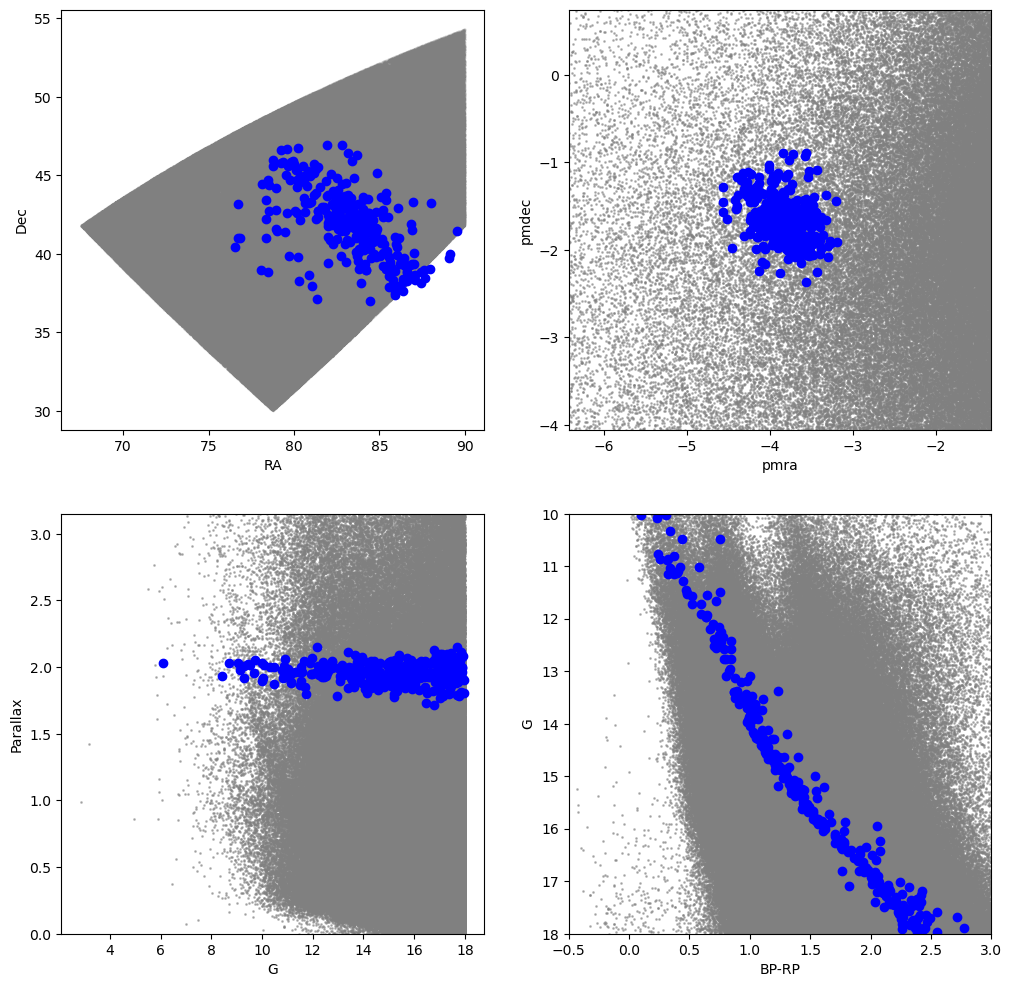

G <= 12.0
	OC members: 44
	Field stars: 24071
	# HDBscan Groups: 45
		Group 4:
			 # members: 10
			 # crossmatched stars: 2
		Group 6:
			 # members: 37
			 # crossmatched stars: 27
47.0
	Purity: 0.6170212765957447
	Completeness: 0.6590909090909091
G <= 13.0
	OC members: 66
	Field stars: 58693
	# HDBscan Groups: 87
		Group 3:
			 # members: 14
			 # crossmatched stars: 5
		Group 4:
			 # members: 66
			 # crossmatched stars: 44
80.0
	Purity: 0.6125
	Completeness: 0.7424242424242424
G <= 14.0
	OC members: 108
	Field stars: 136084
	# HDBscan Groups: 179
		Group 11:
			 # members: 18
			 # crossmatched stars: 9
		Group 12:
			 # members: 105
			 # crossmatched stars: 70
123.0
	Purity: 0.6422764227642277
	Completeness: 0.7314814814814815
G <= 15.0
	OC members: 157
	Field stars: 295288
	# HDBscan Groups: 339
		Group 12:
			 # members: 134
			 # crossmatched stars: 108
		Group 13:
			 # members: 18
			 # crossmatched stars: 11
152.0
	Purity: 0.7828947368421053
	Completeness: 0.7579617834394

In [99]:
purityCOIN, completenessCOIN = ClusterAndCrossmatch(field_COIN, mean_dr3, memb_dr3, 'COIN-Gaia_13', doclust=True)

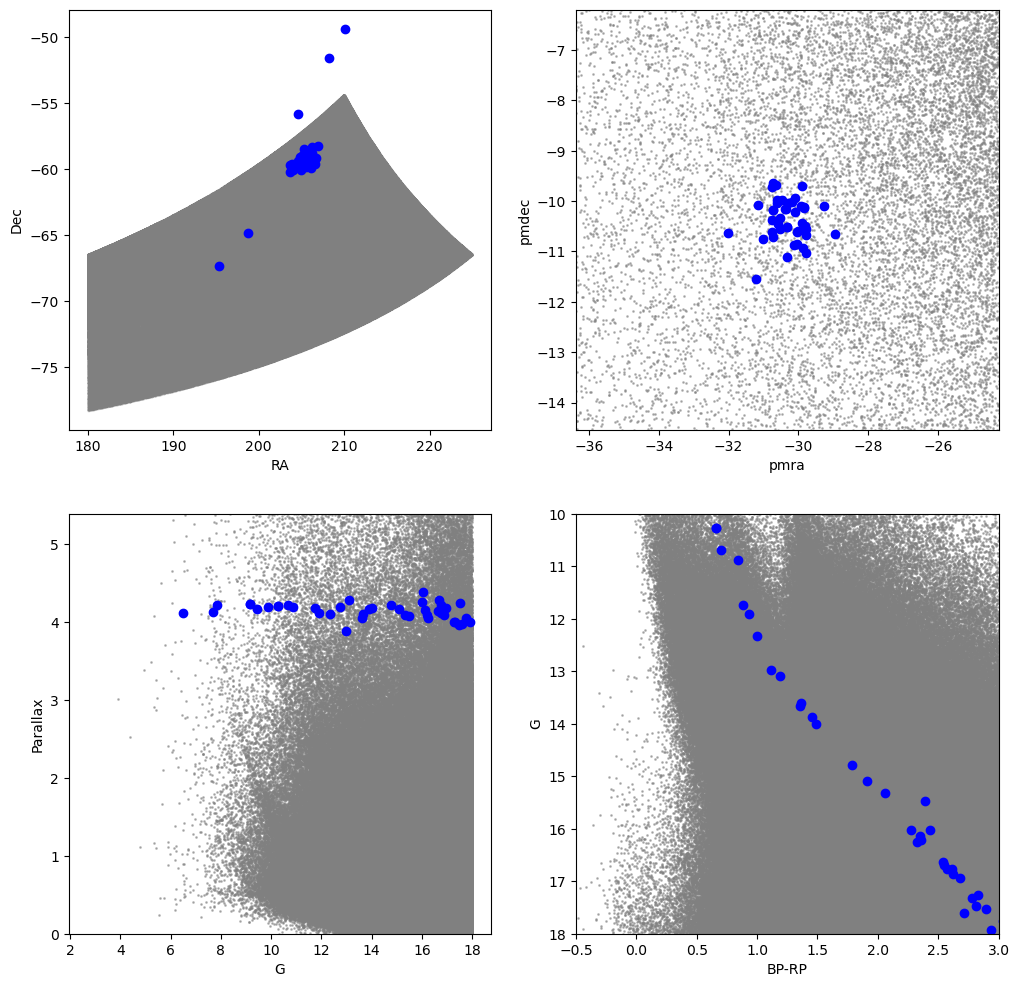

G <= 12.0
	OC members: 13
	Field stars: 48872


FileNotFoundError: [Errno 2] No such file or directory: 'Data\\Platais_10\\clusterer\\clusterer_Platais_10_mag12.0.pkl'

In [ ]:
purityPlatais, completenessPlatais = ClusterAndCrossmatch(field_Platais10, mean_dr3, memb_dr3, 'Platais_10', doclust=True)

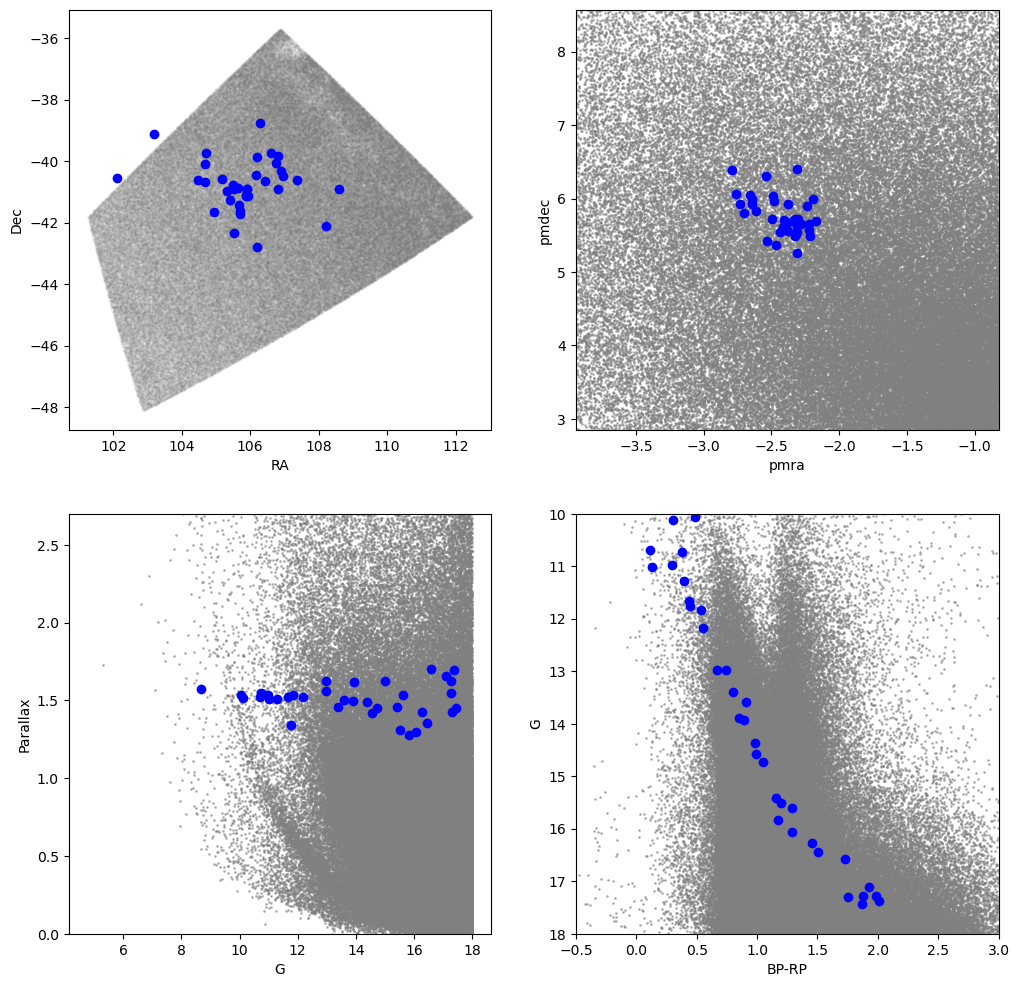

G <= 12.0
	OC members: 11
	Field stars: 4753


FileNotFoundError: [Errno 2] No such file or directory: 'Data\\UPK_495\\clusterer\\clusterer_UPK_495_mag12.0.pkl'

In [ ]:
purityUPK495, completenessUPK459 = ClusterAndCrossmatch(field_UPK495, mean_dr3, memb_dr3, 'UPK_495', doclust=True)

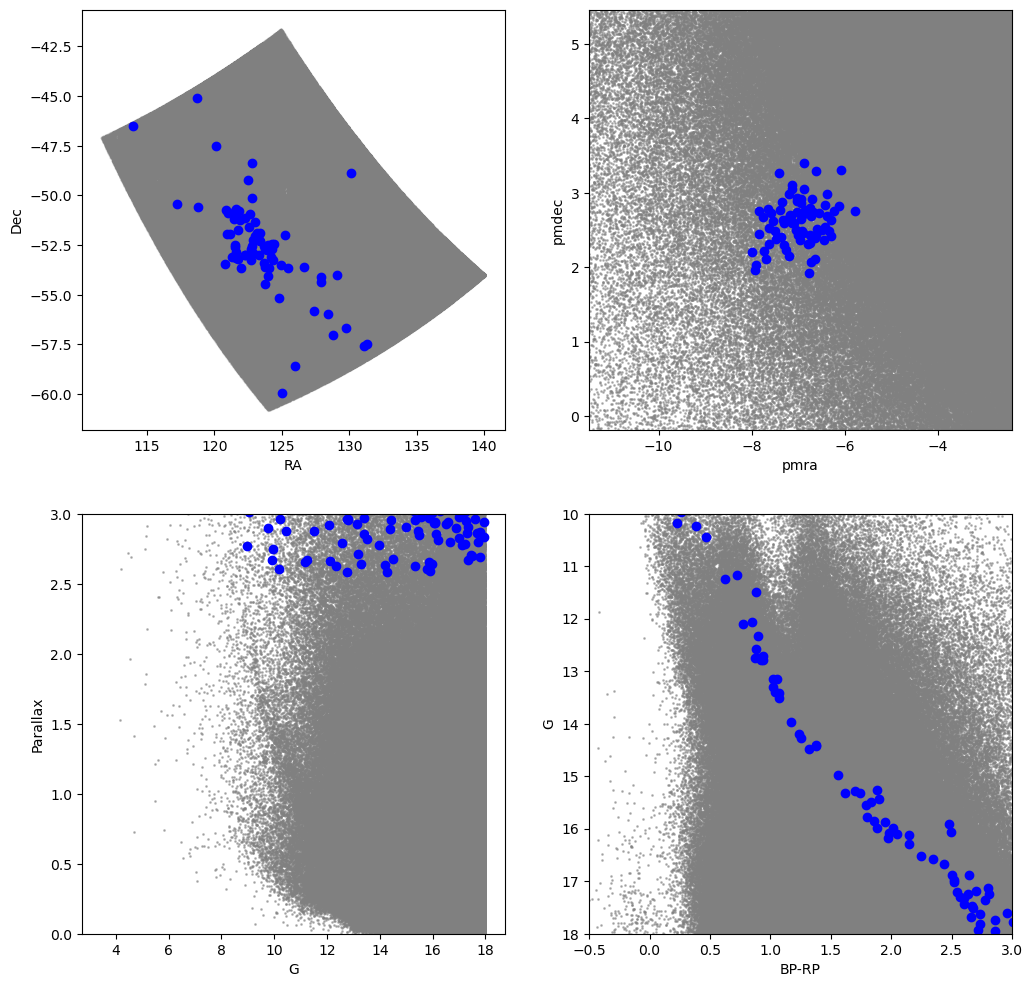

G <= 12.0
	OC members: 12
	Field stars: 24460


FileNotFoundError: [Errno 2] No such file or directory: 'Data\\UPK_533\\clusterer\\clusterer_UPK_533_mag12.0.pkl'

In [ ]:
purityUPK533, completenessUPK533 = ClusterAndCrossmatch(field_UPK533, mean_dr3, memb_dr3, 'UPK_533', doclust=True)

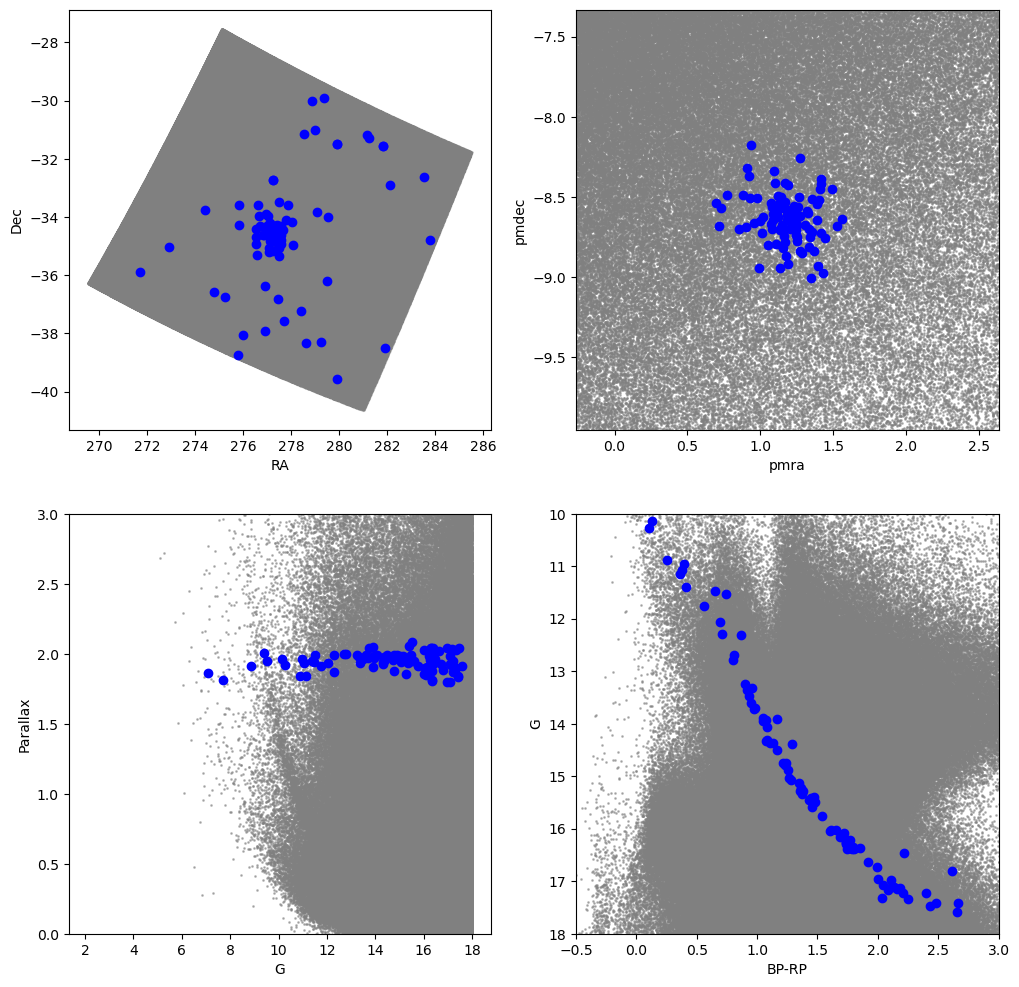

G <= 12.0
	OC members: 15
	Field stars: 21719


FileNotFoundError: [Errno 2] No such file or directory: 'Data\\UPK_654\\clusterer\\clusterer_UPK_654_mag12.0.pkl'

In [ ]:
purityUPK654, completenessUPK654 = ClusterAndCrossmatch(field_UPK654, mean_dr3, memb_dr3, 'UPK_654', doclust=True)